# Purpose

The purpose of these slides are to introduce a toolbox for mathematical modeling and simulation for students who are interested in learning about these topics. With a versatile toolbox, there is no problem that you cannot solve.

Overview of the tools used:
- Linear Regression
- Monte Carlo Simulation
- Problems with States
- Solving ODEs
- Interpolation Methods

These materials were meant for a SIAM Bootcamp with some materials from [APAM 4300](https://github.com/mandli/intro-numerical-methods).

<img src="images/math.png" width = 700>

# Importing Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
%matplotlib inline

# Linear Regression

Linear Regression is a commonly used technique in order to try to build a model or determine how two variables are related.

## Example 1

In this following example, we are going to solve for the coefficients for the line f(x) = ax + b and return the error.

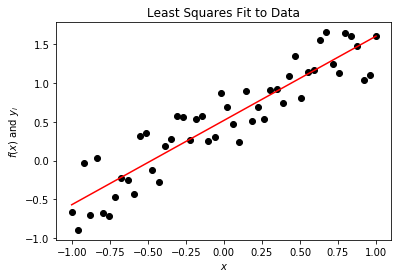

E = 1.863167981692129


In [2]:
N = 50
x = np.linspace(-1.0, 1.0, N)
y = x + np.random.random((N)) 

A = np.ones((x.shape[0], 2))
A[:, 1] = x
p = np.linalg.solve(np.dot(A.transpose(), A), np.dot(A.transpose(), y))
# p = numpy.linalg.lstsq(A, y)[0]
f = lambda x: p[0] + p[1] * x
E = np.linalg.norm(y - f(x), ord=2)

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

axes.plot(x, y, 'ko')
axes.plot(x, f(x), 'r')
axes.set_title("Least Squares Fit to Data")
axes.set_xlabel("$x$")
axes.set_ylabel("$f(x)$ and $y_i$")

plt.show()
print("E = %s" % E)

## Example 2

In this next example, we are going to introduce using sklearn's built-in linear regression in order to predict a simple trend based on past data.

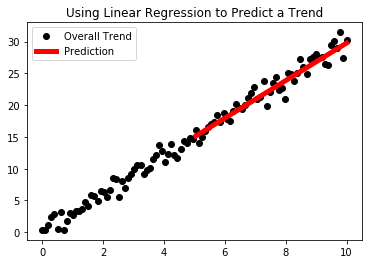

In [43]:
#imports
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Lets make some data
create_data = lambda x: 3*x

x = np.linspace(0,10,100)

x= x[:, np.newaxis]

y=create_data(x)+np.random.randn(100,1)

plt.plot(x,y,'ko',label="Overall Trend")

y_train, y_test = y[:50],y[50:]
x_train, x_test= x[:50],x[50:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(x_test)

plt.title("Using Linear Regression to Predict a Trend")
plt.plot(x_test,y_pred,"r-",label="Prediction",linewidth=5)
plt.legend()

## Example 3: Least Squares for Log Fit

This example is an illustration of how we can use Linear Regression/Least Squares Fitting to determine coefficients for a power law with real experimental data:

We believe that the decay in moment with an increase of magnetic field is due to normal and superconducting phase coexistence and these tend to follow power law behaviours. Therefore we attempt to fit a power law to the behaviour in the domain between HC1 and HC2 with the following procedure:

We begin assuming the behavior follows this law: $\text{M} = c(B_a)^d$ for two constants: c,d. 

We have M is moment and $B_a$ is applied field. In order to fit this we then take the log of both sides:

$$ \log(M) = \log(c)-d\log(B_a) $$

This we can fit with a least squares fit if we set the variable $\hat{c}=\log(c)$.

$$
    \begin{bmatrix}
            1 & -log(B_{a_1}) \\
            1 & -log(B_{a_2}) \\
            \vdots & \vdots \\
            1 & -log(B_{a_k})
     \end{bmatrix}
    \begin{bmatrix}
        \hat{c} \\
        d
    \end{bmatrix}=
    \begin{bmatrix}
           log(M_1) \\
           log(M_2) \\
           \vdots \\
           log(M_k)
    \end{bmatrix}
$$

Solving this using the numpy.linalg.lstsq function we get values for c and d.

### Importing Data

In [12]:
import pandas as pd

In [13]:
test_50k = pd.read_csv("./data/MVH-30000OE-50K.csv")
low_moment_test_50k = test_50k[abs(test_50k["Moment (emu)"])<0.2]

### Fitting Data

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


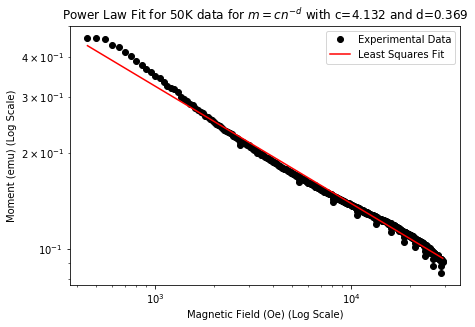

In [23]:
import numpy as np
### BEGIN SOLUTION
e = np.array(abs(test_50k["Moment (emu)"][10:600]))
n = np.array(abs(test_50k["Magnetic Field (Oe)"][10:600]))

#Rough smoothing
for i in range(len(e)):
    if np.isnan(e[i]):
        e[i] = (e[i+1]+e[i-1])/2
        
for i in range(len(n)):
    if np.isnan(n[i]):
        n[i] = (n[i+1]+n[i-1])/2

# Construct coefficient matrix
A = np.ones((n.shape[0], 2))
A[:, 1] = -np.log(n)
coeff = np.linalg.lstsq(A, np.log(e))[0]
c = np.exp(coeff[0])
d = coeff[1]

fig = plt.figure()
axes = fig.add_subplot(1, 2, 1)
axes.loglog(n, e, 'ko',label="Experimental Data")
axes.plot(n, c*n**(-d),'r-',label="Least Squares Fit")
axes.set_xlabel("Magnetic Field (Oe) (Log Scale)")
axes.set_ylabel("Moment (emu) (Log Scale)")
axes.set_title(r"Power Law Fit for 50K data for $m=cn^{-d}$ with c=%.3f and d=%.3f" % (c,d))
plt.legend()

plt.subplots_adjust(top=1,bottom=0.1,left=0.01,right=2)

Text(0.5,1,'$m=cn^{-d}$ with c=4.132 and d=0.369')

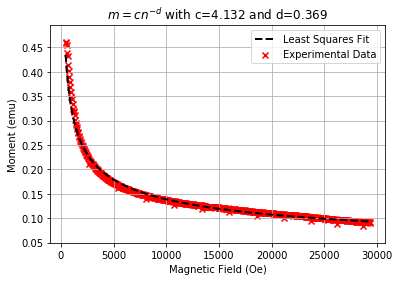

In [19]:
plt.scatter(abs(test_50k["Magnetic Field (Oe)"][10:600]),abs(test_50k["Moment (emu)"][10:600]),label="Experimental Data",marker="x",color="r")
plt.plot(n, c*n**(-d),label="Least Squares Fit",linewidth=2,color='k',linestyle='dashed')
plt.xlabel("Magnetic Field (Oe)")
plt.ylabel("Moment (emu)")
plt.legend()
plt.grid()
plt.title(r"$m=cn^{-d}$ with c=%.3f and d=%.3f" % (c,d))

As we see that the results of the least squares fitting for the power law results in what appears to be a fairly good fit to the experimental data!

# Simple Monte Carlo

## Example 4: Calculating $\pi$
Here is a famous example of how to determine the value of $\pi$, the ratio between the diameter and circumference of the circle, with a simple Monte Carlo simulation.

We are going to throw 100000 random points at a 2x2 box and we are going to see which ones land inside a circle defined by $x^2 + y^2<1$. Then we can take the ratio of these in the circle and divide by the total number of points thrown to get an estimate of $\frac{\pi}{4}$. Multiplying by 4 to this estimate then gives us an estimate for $\pi$.

In [6]:
#Points being thrown
n = 100000
x = 2*np.random.random(n)-1
y = 2*np.random.random(n)-1

#Points in circle
count_in_circle = 0

for i in range(len(x)):
    if x[i]*x[i]+y[i]*y[i]<1:
        count_in_circle+=1

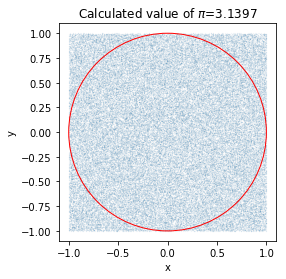

In [7]:
plt.scatter(x,y,s=0.0005)
circle1=plt.Circle((0, 0), 1, color='r',fill=False)
plt.gcf().gca().add_artist(circle1)
plt.title(r"Calculated value of $\pi$=%.4f" % ((4*count_in_circle)/n))
plt.xlabel("x")
plt.ylabel("y")
plt.axis('square');

## States

## Example 5: A Simple Game
Molly and Jenson are playing a game where they are flipping a coin. For each head Molly gets a point, for each tails Jenson gets a point. A person wins when they have two points more than the other person. Molly secretly modified the coin so that it will flip up heads 60% of the time and flip down tails 40% of the time. What is the probability that Molly will win their game?

__Solving__: 
Consider the following state diagram

<img src="images/states.png" width=200px>

With this state diagram, lets consider the probability of Molly winning be p from being tied. Then we can calculate the value of p with help from this state diagram:

<p><center>
    $\begin{align}
p &= 0.6 \cdot 0.6 + 2 \cdot 0.4 \cdot 0.6 p \\
p &= 0.6 \cdot 0.6 + 2 \cdot 0.4 \cdot 0.6 p \\
0.52p &= 0.36\\
p&=.6923
\end{align}$

</center></p>




But who wants to do math, lets simulate it!

In [8]:
def play_game(TOTAL_ITERATION=10000):
    Molly_wins=0
    iteration=0

    while iteration<TOTAL_ITERATION:
        M=0
        J=0
        while (abs(M-J)<2):
            if (np.random.random()<0.6):
                M+=1
            else:
                J+=1
        if M>J:
            Molly_wins+=1
        iteration+=1
        
    return Molly_wins/TOTAL_ITERATION


In [11]:
np.mean([play_game() for i in range(10)])

0.69411

<h2><center>Wow we are pretty damn close!</center></h2>
<img src="images/wow.jpeg" width = 700>

# Solving ODEs

## Example 6: Orbits

Newton's equations for the motion of a particle (he sure gets around doesn't he) in planar orbit with eccentricity $e$ where $0 < e < 1$ are

$$\begin{aligned}
    x''(t) &= -\frac{x}{r^3}, ~~~~ &x(0) &= 1 - e, ~~~~ &x'(0) &= 0, \\
    y''(t) &= -\frac{y}{r^3}, ~~~~ &y(0) &= 0, ~~~~ &y'(0) &= \sqrt{\frac{1 + e}{1 - e}}
\end{aligned}$$

with $r^2 = x^2 + y^2.$

To reformulate this problem as an initial value problem, we redefine the following:

$$\vec{u} = \begin{bmatrix} x \\ x' \end{bmatrix} = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$$
<br>
$$\vec{v} = \begin{bmatrix} y \\ y' \end{bmatrix} = \begin{bmatrix} v_1 \\ v_2 \end{bmatrix}$$

Then to phase it in terms of a system of first-order differential equations:
   
$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} u_2 \\ \frac{-u_1}{(\sqrt{u_1^2 + v_1^2})^{ 3}} \end{bmatrix} = \vec{f}(t, \vec{u})$$

$$\frac{\text{d}}{\text{d}t} \begin{bmatrix} v_1 \\ v_2 \end{bmatrix} = \begin{bmatrix} v_2 \\ \frac{-u_1}{(\sqrt{u_1^2 + v_1^2})^{ 3}} \end{bmatrix} = \vec{g}(t, \vec{v})$$

And we begin with the intial value vectors:
$$\vec{u}_0 = \begin{bmatrix} 1-e \\ 0 \end{bmatrix}$$
<br>
$$\vec{v}_0 = \begin{bmatrix} 0 \\ \sqrt{\frac{1+e}{1-e}} \end{bmatrix}$$

In [64]:
def solve_orbit_RK2_mod(t, e):
    x =[]
    y =[]
    #Setting up the function
    u = np.array([1-e,0])
    v = np.array([0, np.sqrt((1+e)/(1-e))])
    #Will basically use the same function
    f = lambda u, v: np.array([u[1], -u[0]/((np.sqrt(u[0]**2+v[0]**2)**3))])
    x.append(u[0])
    y.append(v[0])
    
    #timestepping
    for i in range(len(t)-1):
        delta_t = abs(t[1]-t[0])
        #So that we can evaluate simulaneously 
        u_1 = u.copy()
        v_1 = v.copy()
        #First stage
        u = u_1 + 0.5 * delta_t * f(u_1, v_1)
        v = v_1 + 0.5 * delta_t * f(v_1, u_1)
        #Recopy
        u_2 = u.copy()
        v_2 = v.copy()
        #Second Stage
        u = u_1 + delta_t * f(u_2, v_2)
        v = v_1 + delta_t * f(v_2, u_2)
        
        x.append(u[0])
        y.append(v[0])
    
    return np.array(x), np.array(y)

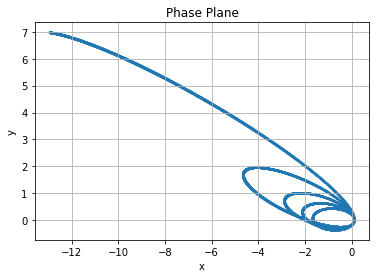

In [65]:
t = np.linspace(0.0, 100.0, 10000)
e = 0.9

x,y = solve_orbit_RK2_mod(t,e)
plt.scatter(x,y,s=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Phase Plane")
plt.grid()

# Interpolation Methods

Interpolation methods as defined by wiki is, "a method for constructing new data points within the range of a discrete set of known data points". In the following example, we are going to present an example of using a interpolation in order to aid in trying to determine a specific temperature in magnetic moment measurements.

## Example: Determining Neel Temperature

In order to determine the Neel temperature, we wanted take the derivative of the susceptibility and determine when this is zero, however trying to apply the standard numpy library function np.gradient() fails due to the noise in the experimental data. Therefore we performed the following preprocessing procedure on the data:

First we fitted a smooth polynomial to the data (of degree 15): we determine the coefficients $a_0, a_1, a_2, ..., a_{15}$. The following is the form of the polynomial that we fitted.


$$ y=\sum\limits_{i=0}^{15} a_{i}x^{i} $$

We then used a Savitzkyâ€“Golay filter, a technique used to smooth data by fitting sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares (Wiki). The parameters than can be adjusted in this technique are the number of adjacent points that can be considered and the degree of the low degree polynomial used in the linear least squares fit.

Considering with Savitzky with polynomials of degree 2 and the number of adjacent points considered in the least squares fit as 25, we achieve the following fit.

In [28]:
s1T = pd.read_csv('./data/MN-MOMENT-VS-TEMP-10000OE_00001.csv').dropna(subset=['Moment (emu)'])
s1T_ZFC = s1T[:math.floor(s1T.shape[0] / 3)]

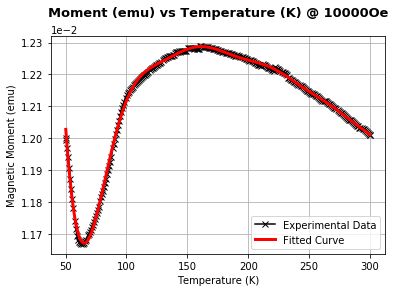

In [32]:
s1T = pd.read_csv('./data/MN-MOMENT-VS-TEMP-10000OE_00001.csv').dropna(subset=['Moment (emu)'])
s1T_ZFC = s1T[:math.floor(s1T.shape[0] / 3)]

plt.plot(s1T_ZFC['Temperature (K)'][::50],s1T_ZFC['Moment (emu)'][::50],marker='x', color='k',label="Experimental Data")

a = np.polyfit(s1T_ZFC['Temperature (K)'][::50],s1T_ZFC['Moment (emu)'][::50],15)
f = lambda x: np.dot(np.array([x**i for i in range(len(a+1))]),a[::-1])
output = [f(i) for i in s1T_ZFC['Temperature (K)'][::50]]
plt.plot(s1T_ZFC['Temperature (K)'][::50],output,c='r',linewidth=3,label="Fitted Curve")
plt.xlabel("Temperature (K)")
plt.ylabel(r"Magnetic Moment (emu)")
custom = {'fontsize':13,'fontweight':'bold'}
plt.title(r"Moment (emu) vs Temperature (K) @ 10000Oe",pad=20,fontdict=custom)
plt.legend()
plt.grid()

#additional parameters


plt.ticklabel_format(axis='y',style='sci',scilimits=(1,4))

### Taking the resulting derivative yields the following

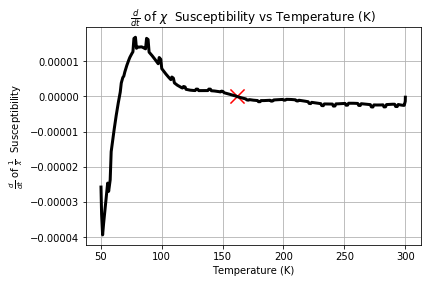

In [39]:
plt.plot(s1T_ZFC['Temperature (K)'][::50],np.gradient(output),c='k',linewidth=3)
plt.ylabel(r"$\frac{d}{dt}$ of $\frac{1}{\chi}$  Susceptibility")
plt.xlabel("Temperature (K)")
plt.title(r"$\frac{d}{dt}$ of $\chi$  Susceptibility vs Temperature (K)")
plt.grid()

### In order to remove the noise we then apply the Savgol Filter

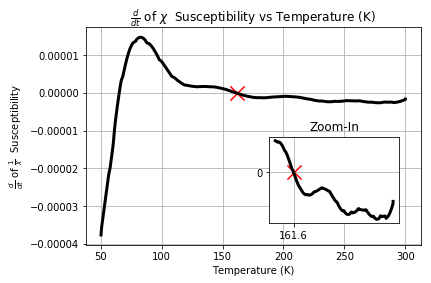

In [40]:
a = np.gradient(output)
b = savgol_filter(a, 25, 2)

np.where(np.diff(np.sign(b)))[0]
points_near_zero = [(s1T_ZFC['Temperature (K)'][::50].values[k],b[k]) for k in np.where(np.diff(np.sign(b)))[0]]

#plt.plot(s1T_ZFC['Temperature (K)'][::50],np.gradient(output))
plt.plot(s1T_ZFC['Temperature (K)'][::50],b,c='k',linewidth=3)
plt.scatter(points_near_zero[1][0],points_near_zero[1][1],marker='x',s=200,c='r')
plt.ylabel(r"$\frac{d}{dt}$ of $\frac{1}{\chi}$  Susceptibility")
plt.xlabel("Temperature (K)")
plt.title(r"$\frac{d}{dt}$ of $\chi$  Susceptibility vs Temperature (K)")
plt.grid()

a = plt.axes([0.55, 0.2, .3, .3])
plt.plot(s1T_ZFC['Temperature (K)'][::50][100:],b[100:],c='k',linewidth=3)
plt.scatter(points_near_zero[1][0],points_near_zero[1][1],marker='x',s=200,c='r')
plt.title('Zoom-In')
plt.xticks([161.62])
plt.yticks([0])
plt.grid()

# Conclusion

In conclusion, we present a couple of really useful mathematical tools and examples of how some of them are used to help start the journey of building a mathematical toolbox.

## Cool Notebooks You Should Also Check Out

https://rajeshrinet.github.io/blog/2014/ising-model/

http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb

https://github.com/INASIC/predator-prey_systems/blob/master/Modelling%20Predator-Prey%20Systems%20in%20Python.ipynb